In [1]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
config = {}

config['path_to_data'] = data_path+"ids/data/"

config['path_to_outdata'] = data_path+"ids/data/"

config['path_to_figures'] = data_path+"ids/figures/"

## experiment 1
config['date1'] = "2024-01-29"
config['date2'] = "2024-02-05"

## experiment 2
config['date1'] = "2024-02-15"
config['date2'] = "2024-02-23"

## experiment 2
config['date1'] = "2024-03-09"
config['date2'] = "2024-03-28"


In [5]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

In [6]:
mltiU = __load_mlti(config['date1'], config['date2'], "U", archive_path)
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [7]:
def __load_beam_wander_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"{str(dat)[:10].replace('-','')}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

    return df

In [8]:
df = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'])

2024-03-09
2024-03-10
2024-03-11
2024-03-12
2024-03-13
error for 20240313.pkl
2024-03-14
error for 20240314.pkl
2024-03-15
2024-03-16
2024-03-17
2024-03-18
2024-03-19
2024-03-20
error for 20240320.pkl
2024-03-21
2024-03-22
2024-03-23
2024-03-24
2024-03-25
2024-03-26
2024-03-27
2024-03-28
error for 20240328.pkl


### Remove MLTI times

In [9]:

# local time to utc (! correct only in winter)
df['time_utc'] = [UTCDateTime(tl)-3600 for tl in df.time]


# pixel to length
conversion_factor = 1.67e-3 # mm / pixel

keys_to_convert = ["y_idx", "x_idx", "y", "x"]

for k in keys_to_convert:
    df[k] *= conversion_factor

# turn times with MLTI to NaN
df = __mlti_intervals_to_NaN(df, "y_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)
df = __mlti_intervals_to_NaN(df, "x_idx", "time_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)


In [10]:
df

time         x         y    x_idx    y_idx  \
0     2024-03-09T00:16:04.000000Z  3.448152  1.623167  3.44688  1.62324   
1     2024-03-09T00:18:04.000000Z  3.448166  1.623070  3.44688  1.62324   
2     2024-03-09T00:32:04.000000Z  3.448276  1.623338  3.44688  1.62324   
3     2024-03-09T00:45:05.000000Z  3.448335  1.623647  3.44688  1.62324   
4     2024-03-09T00:51:04.000000Z  3.448354  1.623493  3.44688  1.62324   
...                           ...       ...       ...      ...      ...   
2073  2024-03-27T23:07:05.000000Z  3.528537  1.678036  3.52704  1.67668   
2074  2024-03-27T23:13:04.000000Z  3.528517  1.678003  3.52704  1.67668   
2075  2024-03-27T23:18:04.000000Z  3.528574  1.678042  3.52704  1.67668   
2076  2024-03-27T23:35:04.000000Z  3.528626  1.678079  3.52704  1.67668   
2077  2024-03-27T23:55:04.000000Z  3.528729  1.678370  3.52704  1.67835   

             amp       x_sig       y_sig     theta    offset  ...     y_var  \
0     118.640974  512.482534  488.616501  0.442582  9.262870  ...  0.004833   
1     118.576590  512.446876  488.572016  0.442970  9.261224  ...  0.004832   
2     118.430879  512.472021  488.643493  0.443508  9.262004  ...  0.004837   
3     118.532076  512.453585  488.643372  0.443924  9.255072  ...  0.004839   
4     118.460598  512.491885  488.660101  0.443797  9.259604  ...  0.004840   
...          ...         ...         ...       ...       ...  ...       ...   
2073  123.523173  514.983365  491.605396  0.507117  9.430849  ...  0.005268   
2074  123.315621  515.016305  491.624179  0.506632  9.434908  ...  0.005265   
2075  123.395341  514.976746  491.609018  0.507311  9.435119  ...  0.005266   
2076  123.595845  515.016462  491.626134  0.506840  9.434177  ...  0.005262   
2077  123.539963  515.010146  491.655387  0.508374  9.432846  ...  0.005266   

       amp_var  y_sig_var  x_sig_var  theta_var  offset_var   time_sec  \
0     0.000277   0.006100   0.006563   0.000004    0.000021        0.0   
1     0.000277   0.006098   0.006561   0.000004    0.000021      120.0   
2     0.000276   0.006104   0.006567   0.000004    0.000021      960.0   
3     0.000277   0.006106   0.006569   0.000004    0.000021     1741.0   
4     0.000277   0.006107   0.006571   0.000004    0.000021     2100.0   
...        ...        ...        ...        ...         ...        ...   
2073  0.000323   0.006620   0.007177   0.000005    0.000026  1637461.0   
2074  0.000322   0.006617   0.007175   0.000005    0.000025  1637820.0   
2075  0.000322   0.006617   0.007174   0.000005    0.000025  1638120.0   
2076  0.000323   0.006613   0.007170   0.000005    0.000026  1639140.0   
2077  0.000323   0.006618   0.007174   0.000005    0.000026  1640340.0   

                         time_utc y_idx_nan  x_idx_nan  
0     2024-03-08T23:16:04.000000Z   1.62324    3.44688  
1     2024-03-08T23:18:04.000000Z   1.62324    3.44688  
2     2024-03-08T23:32:04.000000Z   1.62324    3.44688  
3     2024-03-08T23:45:05.000000Z   1.62324    3.44688  
4     2024-03-08T23:51:04.000000Z   1.62324    3.44688  
...                           ...       ...        ...  
2073  2024-03-27T22:07:05.000000Z   1.67668    3.52704  
2074  2024-03-27T22:13:04.000000Z   1.67668    3.52704  
2075  2024-03-27T22:18:04.000000Z   1.67668    3.52704  
2076  2024-03-27T22:35:04.000000Z   1.67668    3.52704  
2077  2024-03-27T22:55:04.000000Z   1.67835    3.52704  

[2078 rows x 21 columns]

### Plotting

In [11]:
from functions.reduce import __reduce

In [12]:
df['x_um_rel'] = __reduce(df.x, 10) * 1e3
df['y_um_rel'] = __reduce(df.y, 10) * 1e3

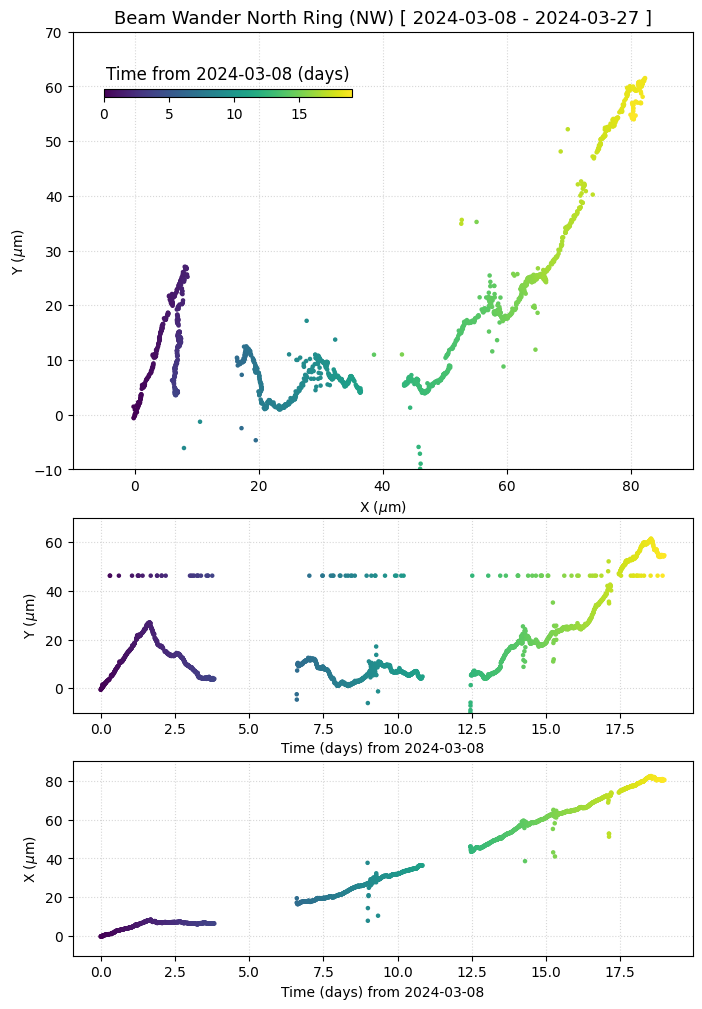

In [27]:
def __makeplot_beam_wander(df0):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    time_scaling = 1/86400

    Ncol, Nrow = 2, 4

    font = 12

    fig = plt.figure(figsize=(8, 12))

    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs[0:2, :])

    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3, :])

    plt.subplots_adjust(hspace=0.25)

    # ax1.scatter(df0.x_idx, df0.y_idx, c=df0.time_sec*time_scaling, s=5, zorder=2)
    # cb = ax1.scatter(df0.x, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)
    cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)

    # ax2.scatter(df0.time_sec*time_scaling, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)
    # ax3.scatter(df0.time_sec*time_scaling, df0.x, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)

    ax1.set_ylabel("Y ($\mu$m)")
    ax1.set_xlabel("X ($\mu$m)")

    ax2.set_ylabel("Y ($\mu$m)")
    ax2.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    ax3.set_ylabel("X ($\mu$m)")
    ax3.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    # x1, x2 = 3.44, 3.52
    # y1, y2 = 1.62, 1.66
    x1, x2 = -10, 90
    y1, y2 = -10, 70
    ax1.set_xlim(x1, x2)
    ax1.set_ylim(y1, y2)
    ax2.set_ylim(y1, y2)
    ax3.set_ylim(x1, x2)

    # add title
    ax1.set_title(f"Beam Wander North Ring (NW) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    # add colorbar
    cax1 = ax1.inset_axes([0.05, 0.85, 0.4, 0.02])
    cb5 = plt.colorbar(cb, ax=ax1, cax=cax1, orientation="horizontal")
    cb5.set_label(f"Time from {df0.time_utc.iloc[0].date} (days)", fontsize=font, labelpad=-40)


    plt.show();
    return fig

fig = __makeplot_beam_wander(df)

fig.savefig(config['path_to_figures']+f"BeamWander_RU.png", format="png", dpi=150, bbox_inches='tight')


In [14]:
df

time         x         y    x_idx    y_idx  \
0     2024-03-09T00:16:04.000000Z  3.448152  1.623167  3.44688  1.62324   
1     2024-03-09T00:18:04.000000Z  3.448166  1.623070  3.44688  1.62324   
2     2024-03-09T00:32:04.000000Z  3.448276  1.623338  3.44688  1.62324   
3     2024-03-09T00:45:05.000000Z  3.448335  1.623647  3.44688  1.62324   
4     2024-03-09T00:51:04.000000Z  3.448354  1.623493  3.44688  1.62324   
...                           ...       ...       ...      ...      ...   
2073  2024-03-27T23:07:05.000000Z  3.528537  1.678036  3.52704  1.67668   
2074  2024-03-27T23:13:04.000000Z  3.528517  1.678003  3.52704  1.67668   
2075  2024-03-27T23:18:04.000000Z  3.528574  1.678042  3.52704  1.67668   
2076  2024-03-27T23:35:04.000000Z  3.528626  1.678079  3.52704  1.67668   
2077  2024-03-27T23:55:04.000000Z  3.528729  1.678370  3.52704  1.67835   

             amp       x_sig       y_sig     theta    offset  ...  y_sig_var  \
0     118.640974  512.482534  488.616501  0.442582  9.262870  ...   0.006100   
1     118.576590  512.446876  488.572016  0.442970  9.261224  ...   0.006098   
2     118.430879  512.472021  488.643493  0.443508  9.262004  ...   0.006104   
3     118.532076  512.453585  488.643372  0.443924  9.255072  ...   0.006106   
4     118.460598  512.491885  488.660101  0.443797  9.259604  ...   0.006107   
...          ...         ...         ...       ...       ...  ...        ...   
2073  123.523173  514.983365  491.605396  0.507117  9.430849  ...   0.006620   
2074  123.315621  515.016305  491.624179  0.506632  9.434908  ...   0.006617   
2075  123.395341  514.976746  491.609018  0.507311  9.435119  ...   0.006617   
2076  123.595845  515.016462  491.626134  0.506840  9.434177  ...   0.006613   
2077  123.539963  515.010146  491.655387  0.508374  9.432846  ...   0.006618   

      x_sig_var  theta_var  offset_var   time_sec  \
0      0.006563   0.000004    0.000021        0.0   
1      0.006561   0.000004    0.000021      120.0   
2      0.006567   0.000004    0.000021      960.0   
3      0.006569   0.000004    0.000021     1741.0   
4      0.006571   0.000004    0.000021     2100.0   
...         ...        ...         ...        ...   
2073   0.007177   0.000005    0.000026  1637461.0   
2074   0.007175   0.000005    0.000025  1637820.0   
2075   0.007174   0.000005    0.000025  1638120.0   
2076   0.007170   0.000005    0.000026  1639140.0   
2077   0.007174   0.000005    0.000026  1640340.0   

                         time_utc  y_idx_nan  x_idx_nan   x_um_rel   y_um_rel  
0     2024-03-08T23:16:04.000000Z    1.62324    3.44688  -0.139370  -0.535692  
1     2024-03-08T23:18:04.000000Z    1.62324    3.44688  -0.125655  -0.633010  
2     2024-03-08T23:32:04.000000Z    1.62324    3.44688  -0.015832  -0.365117  
3     2024-03-08T23:45:05.000000Z    1.62324    3.44688   0.042955  -0.056395  
4     2024-03-08T23:51:04.000000Z    1.62324    3.44688   0.061717  -0.210533  
...                           ...        ...        ...        ...        ...  
2073  2024-03-27T22:07:05.000000Z    1.67668    3.52704  80.245502  54.333406  
2074  2024-03-27T22:13:04.000000Z    1.67668    3.52704  80.225479  54.299624  
2075  2024-03-27T22:18:04.000000Z    1.67668    3.52704  80.281820  54.339170  
2076  2024-03-27T22:35:04.000000Z    1.67668    3.52704  80.333974  54.376249  
2077  2024-03-27T22:55:04.000000Z    1.67835    3.52704  80.437435  54.666672  

[2078 rows x 23 columns]

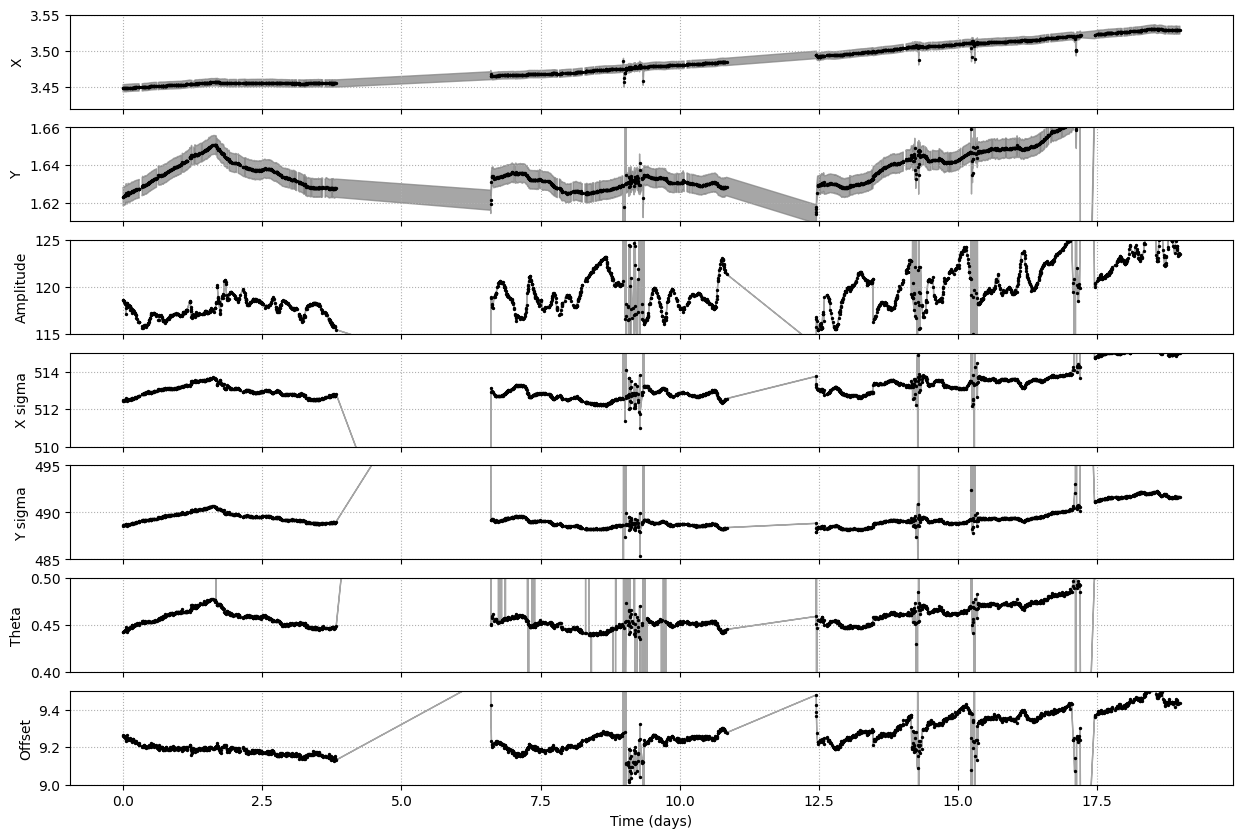

In [20]:
def __makeplot():

    Nrow, Ncol = 7, 1

    font = 12
    size = 2
    tscale = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    ax[0].fill_between(df.time_sec*tscale, df.x-df.x_var, df.x+df.x_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[0].scatter(df.time_sec*tscale, df.x, s=size, zorder=2, color="k")
    ax[0].set_ylim(3.42, 3.55)
    ax[0].set_ylabel("X")

    ax[1].fill_between(df.time_sec*tscale, df.y-df.y_var, df.y+df.y_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[1].scatter(df.time_sec*tscale, df.y, s=size, zorder=2, color="k")
    ax[1].set_ylim(1.61, 1.66)
    ax[1].set_ylabel("Y")

    ax[2].fill_between(df.time_sec*tscale, df.amp-df.amp_var, df.amp+df.amp_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[2].scatter(df.time_sec*tscale, df.amp, s=size, zorder=2, color="k")
    ax[2].set_ylim(115, 125)
    ax[2].set_ylabel("Amplitude")

    ax[3].fill_between(df.time_sec*tscale, df.x_sig-df.x_sig_var, df.x_sig+df.x_sig_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[3].scatter(df.time_sec*tscale, df.x_sig, s=size, zorder=2, color="k")
    ax[3].set_ylim(510, 515)
    ax[3].set_ylabel("X sigma")

    ax[4].fill_between(df.time_sec*tscale, df.y_sig-df.y_sig_var, df.y_sig+df.y_sig_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[4].scatter(df.time_sec*tscale, df.y_sig, s=size, zorder=2, color="k")
    ax[4].set_ylim(485, 495)
    ax[4].set_ylabel("Y sigma")

    ax[5].fill_between(df.time_sec*tscale, df.theta-df.theta_var, df.theta+df.theta_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[5].scatter(df.time_sec*tscale, df.theta, s=size, zorder=2, color="k")
    ax[5].set_ylim(0.4, 0.5)
    ax[5].set_ylabel("Theta")

    ax[6].fill_between(df.time_sec*tscale, df.offset-df.offset_var, df.offset+df.offset_var,
                       color="grey", alpha=0.7, interpolate=False
                      )
    ax[6].scatter(df.time_sec*tscale, df.offset, s=size, zorder=2, color="k")
    ax[6].set_ylim(9, 9.5)
    ax[6].set_ylabel("Offset")

    ax[6].set_xlabel("Time (days)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1)

    plt.show();
    return fig


fig = __makeplot();

(3.425, 3.53)

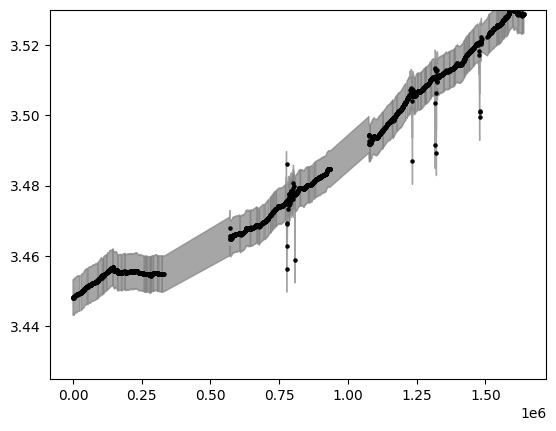

In [29]:
plt.fill_between(df.time_sec, df.x-df.x_var, df.x+df.x_var, color="grey", alpha=0.7, interpolate=False)

plt.scatter(df.time_sec, df.x, color="k", s=5, zorder=2)
plt.ylim(3.425, 3.53)